# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

In [13]:
# Reload module in case of changes
importlib.reload(utils)

<module 'lib.utils' from '/Users/floyd/Documents/Studium/BAE/continuous_training_using_ensemble_networks/notebooks/../lib/utils.py'>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

## Load preprocessed dataset

In [2]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=30)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(10,), dtype=tf.float32))

2022-04-01 14:12:25.410385: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Have a look at the normal data

2022-03-23 22:14:02.779284: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


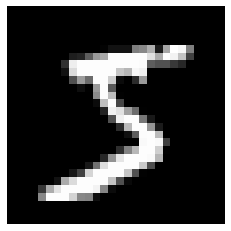

In [3]:
for x, y in train_ds_pre.take(1):
    utils.plot(x)

## Have a look at the generator data

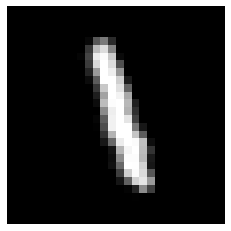

In [18]:
for x, y in train_generator:
    utils.plot(tf.convert_to_tensor(x))
    break

## Initialize the models

In [3]:
num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
#model3a = networks.NN([256, 256], num_classes)

model3b = networks.CNN([(32, 3), (64, 5)])
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3b, model4, model5])

## Load the weights from pre-training

In [15]:
model1.load_weights('../models/NN128128')
model2.load_weights('../models/NN512')
#model3a.load_weights('../models/NN256256')
model4.load_weights('../models/CNN3264128')
model5.load_weights('../models/CNN163264')

In [18]:
model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3b.load_weights('../models/CNN3264extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

In [17]:
_,_,_ = training.pretraining(model2, train_ds_pre, test_ds, epochs=5)

Epoch: __ 0
LOSS 0.2565476389342471 ::: ACC 0.9238528481012658
Epoch: __ 1
LOSS 0.21039237195177923 ::: ACC 0.940565664556962
Epoch: __ 2
LOSS 0.1859546095675117 ::: ACC 0.9455102848101266
Epoch: __ 3
LOSS 0.16527613955019396 ::: ACC 0.9499604430379747
Epoch: __ 4
LOSS 0.15022341016373492 ::: ACC 0.9553995253164557


## Ensemble accuracy on normal test data after pre training

In [19]:
_, acc = training.test_ensemble(ensemble, test_ds, tf.keras.losses.CategoricalCrossentropy())

Testing models in ensemble
Model: __ 0
LOSS 0.14799747606621513 ::: ACC 0.9567840189873418
Model: __ 1
LOSS 0.15022341016373492 ::: ACC 0.9553995253164557
Model: __ 2
LOSS 0.13765182189313294 ::: ACC 0.9574762658227848
Model: __ 3
LOSS 0.1074675908754285 ::: ACC 0.9657832278481012
Model: __ 4
LOSS 0.1239947147337319 ::: ACC 0.9635087025316456
Ensemble:
LOSS nan ::: ACC 0.9489715189873418


## Ensemble accuracy on augmented after pre-training

In [21]:
_, acc = training.test_ensemble(ensemble, test_generator, tf.keras.losses.CategoricalCrossentropy())

Testing models in ensemble
Model: __ 0
LOSS 0.49893946370611547 ::: ACC 0.8525147485251475
Model: __ 1
LOSS 0.5060726154606998 ::: ACC 0.8542145785421458
Model: __ 2
LOSS 0.4869611615137554 ::: ACC 0.8593140685931406
Model: __ 3
LOSS 0.35735883128605145 ::: ACC 0.8902109789021098
Model: __ 4
LOSS 0.3808865072396109 ::: ACC 0.8844115588441156
Ensemble:
LOSS nan ::: ACC 0.8285171482851715


## Cycle through new data

### Run with third model replaced as CNN (little pretraining)...

#### Plot of the distribution of the collected data per cycle

Cycle:  0
1117.0 collected datapoints labeled correct
249.0 collected datapoints were labeled wrong
1043 datapoints were not classified.


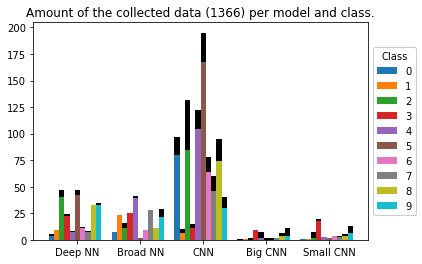

Cycle:  1
2087.0 collected datapoints labeled correct
365.0 collected datapoints were labeled wrong
1096 datapoints were not classified.


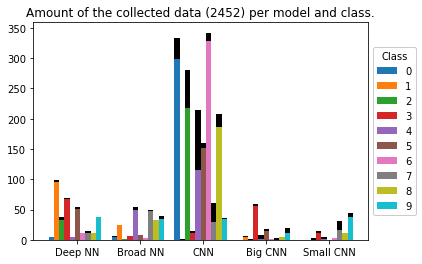

Cycle:  2
1676.0 collected datapoints labeled correct
449.0 collected datapoints were labeled wrong
783 datapoints were not classified.


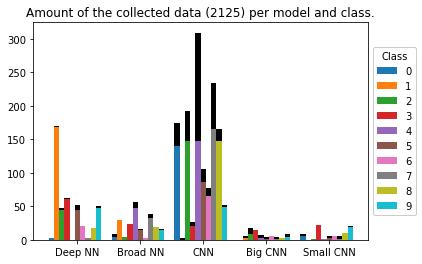

Cycle:  3
1816.0 collected datapoints labeled correct
464.0 collected datapoints were labeled wrong
725 datapoints were not classified.


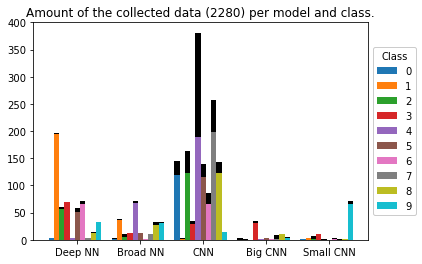

Cycle:  4
2034.0 collected datapoints labeled correct
478.0 collected datapoints were labeled wrong
653 datapoints were not classified.


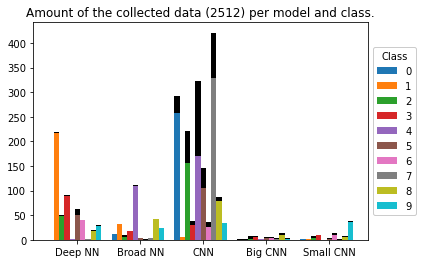

In [15]:
utils.plot_cycles(ensemble, "Run02")

#### The Ensemble accuracy after every Model training per cycle

In [19]:
accloss02 = np.load('../continuous_training_data/Run02_accloss.npz')
pd.DataFrame(accloss02['ensemble_accuracies'],
             columns=['Model_'+str(i) for i in range(accloss02['ensemble_accuracies'].shape[1])]).head(accloss02['ensemble_accuracies'].shape[1])

,Model_0,Model_1,Model_2,Model_3,Model_4
0,0.785621,0.798920,0.788521,0.788621,0.787221
1,0.790821,0.797720,0.797720,0.809219,0.806519
2,0.816118,0.813619,0.818518,0.811319,0.815618
3,0.823318,0.826417,0.824818,0.828517,0.834017
4,0.828017,0.833717,0.830017,0.836416,0.839216


#### The model accuracy after every training per cycle

In [20]:
mta = accloss02['models_test_accuracies'][:,:,-1]
pd.DataFrame(mta,
             columns=['Model_'+str(i) for i in range(mta.shape[1])]).head(mta.shape[1])

,Model_0,Model_1,Model_2,Model_3,Model_4
0,0.786121,0.801420,0.721328,0.860114,0.875912
1,0.790721,0.820218,0.773823,0.882612,0.876212
2,0.803120,0.820118,0.779622,0.889211,0.867013
3,0.810719,0.826617,0.782822,0.896310,0.877812
4,0.820618,0.834317,0.736826,0.898510,0.889811


### Run with third model replaced as CNN (more pretraining)...

#### Plot of the distribution of the collected data per cycle

Cycle:  0
1104.0 collected datapoints labeled correct
250.0 collected datapoints were labeled wrong
1038 datapoints were not classified.


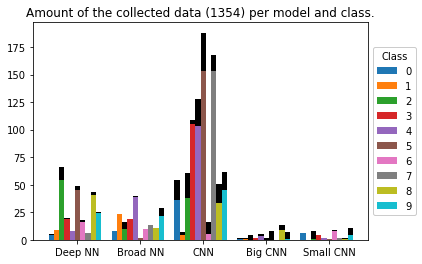

Cycle:  1
1994.0 collected datapoints labeled correct
311.0 collected datapoints were labeled wrong
1041 datapoints were not classified.


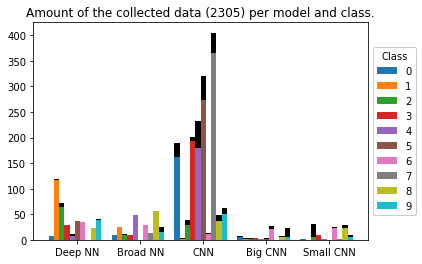

Cycle:  2
1950.0 collected datapoints labeled correct
339.0 collected datapoints were labeled wrong
899 datapoints were not classified.


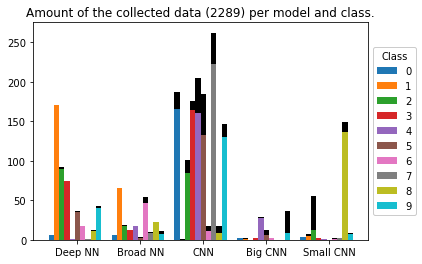

Cycle:  3
2068.0 collected datapoints labeled correct
405.0 collected datapoints were labeled wrong
709 datapoints were not classified.


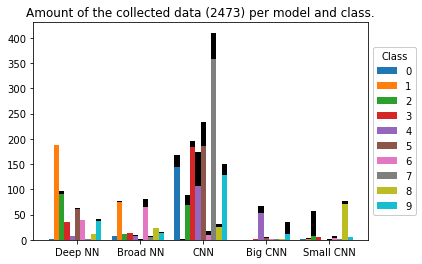

Cycle:  4
2043.0 collected datapoints labeled correct
378.0 collected datapoints were labeled wrong
670 datapoints were not classified.


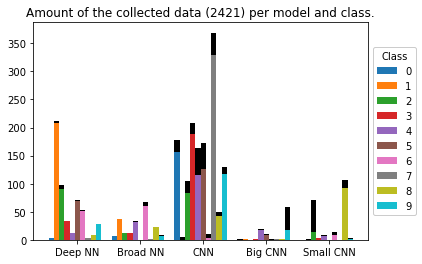

Cycle:  5
1980.0 collected datapoints labeled correct
407.0 collected datapoints were labeled wrong
691 datapoints were not classified.


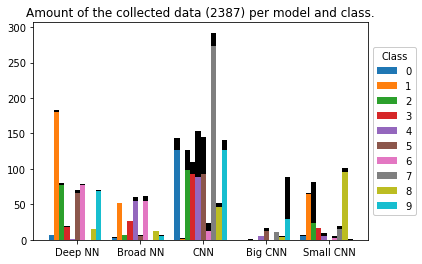

Cycle:  6
1945.0 collected datapoints labeled correct
462.0 collected datapoints were labeled wrong
553 datapoints were not classified.


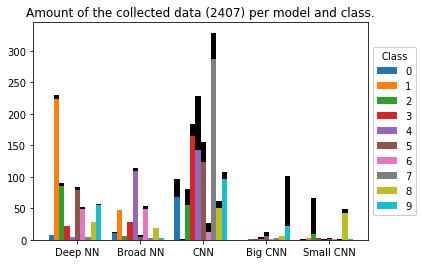

Cycle:  7
2160.0 collected datapoints labeled correct
436.0 collected datapoints were labeled wrong
529 datapoints were not classified.


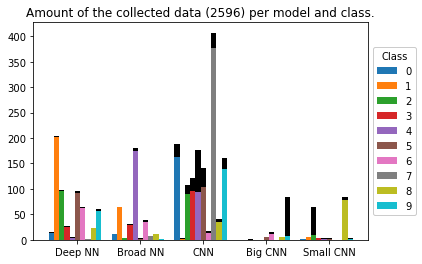

In [14]:
utils.plot_cycles(ensemble, "Run03")

#### The Ensemble accuracy after every Model training per cycle

In [9]:
accloss03 = np.load('../continuous_training_data/Run03_accloss.npz')
pd.DataFrame(accloss03['ensemble_accuracies'],
             columns=['Model_'+str(i) for i in range(accloss03['ensemble_accuracies'].shape[1])]).head(accloss03['ensemble_accuracies'].shape[1])

,Model_0,Model_1,Model_2,Model_3,Model_4
0,0.785021,0.805819,0.796620,0.800520,0.797220
1,0.801420,0.812919,0.804320,0.806719,0.807719
2,0.819318,0.819118,0.818818,0.818218,0.826117
3,0.827217,0.832617,0.832417,0.833117,0.835216
4,0.827517,0.834817,0.832417,0.834817,0.823318


#### The model accuracy after every training per cycle

In [11]:
mta = accloss03['models_test_accuracies'][:,:,-1]
pd.DataFrame(mta,
             columns=['Model_'+str(i) for i in range(mta.shape[1])]).head(mta.shape[1])

,Model_0,Model_1,Model_2,Model_3,Model_4
0,0.790521,0.806419,0.729927,0.888111,0.872013
1,0.783622,0.820818,0.765123,0.895210,0.865713
2,0.810519,0.830217,0.754925,0.890511,0.887611
3,0.811919,0.841716,0.773723,0.894311,0.881712
4,0.817418,0.839416,0.790321,0.896310,0.853615
